In [6]:
import pandas as pd
import numpy as np
df=pd.read_pickle("../Analysis/dailyDataT12138NdlsCsmt.pkl")
df

,journey_date,PSGN
0,2023-08-01,26
1,2023-08-02,16
2,2023-08-03,15
3,2023-08-04,5
4,2023-08-05,19
...,...,...
725,2025-07-27,26
726,2025-07-28,16
727,2025-07-29,21
728,2025-07-30,8


In [7]:
from datetime import timedelta
if ('PSGN' in df.columns):
    df.rename(columns={'PSGN': 'total_psgn'}, inplace=True)

# ---- Holiday dictionary ----
holidays = {
    # 2023
    "26-01-2023": "Republic Day",
    "15-08-2023": "Independence Day",
    "02-10-2023": "Gandhi Jayanti",
    "25-12-2023": "Christmas",
    "12-11-2023": "Diwali",
    "07-03-2023": "Holi",
    "05-09-2023": "Eid",

    # 2024
    "26-01-2024": "Republic Day",
    "15-08-2024": "Independence Day",
    "02-10-2024": "Gandhi Jayanti",
    "25-12-2024": "Christmas",
    "31-10-2024": "Diwali",
    "15-08-2024": "Raksha Bandhan",
    "26-08-2024": "Janmashtami",
    "25-03-2024": "Holi",

    # 2025
    "26-01-2025": "Republic Day",
    "15-08-2025": "Independence Day",
    "02-10-2025": "Gandhi Jayanti",
    "25-12-2025": "Christmas",
    "20-10-2025": "Diwali",
    "31-03-2025": "Holi",
    "05-09-2025": "Eid",
}

holiday_dates = pd.to_datetime(list(holidays.keys()), format='%d-%m-%Y').date


# --- 2. Add Weekday Binary Columns ---
print("Adding weekday binary columns...")
df['is_sunday'] = (df['journey_date'].dt.day_name() == 'Sunday').astype(int)
df['is_saturday'] = (df['journey_date'].dt.day_name() == 'Saturday').astype(int)
df['is_friday'] = (df['journey_date'].dt.day_name()== 'Friday').astype(int)
df['is_rest_day'] = (~df['journey_date'].dt.day_name().isin(['Sunday', 'Saturday', 'Friday'])).astype(int)


# --- 3. Add Seasonal Binary Columns ---
print("Adding seasonal binary columns...")
# Binary column for peak summer season (15th May to 15th June)
df['is_peak_season'] = (
    (df['journey_date'].dt.month == 5) & (df['journey_date'].dt.day >= 15) |
    (df['journey_date'].dt.month == 6) & (df['journey_date'].dt.day <= 15)
).astype(int)

# Binary column for winter months (December and January)
df['is_winter_season'] = df['journey_date'].dt.month.isin([12, 1]).astype(int)


# --- 4. Add Holiday Period Column ---
print("Adding holiday period column...")

# Create sets for near-holidays and long weekends
near_holiday_dates = set()
long_weekend_dates = set()

for holiday in holiday_dates:
    # Add the day before and after the holiday
    # near_holiday_dates.add(holiday - timedelta(days=1))
    # near_holiday_dates.add(holiday + timedelta(days=1))
    
    # Check for long weekends (holiday on Monday or Friday)
    if holiday.weekday() == 0:  # Monday
        long_weekend_dates.update([holiday, holiday - timedelta(days=1), holiday - timedelta(days=2), holiday - timedelta(days=3)])
    elif holiday.weekday() == 4:  # Friday
        long_weekend_dates.update([holiday, holiday + timedelta(days=1), holiday + timedelta(days=2), holiday + timedelta(days=3)])

# Combine all special dates into one large set
holiday_period_dates = set(holiday_dates) | near_holiday_dates | long_weekend_dates

# Create the final binary column by checking if the journey date is in the combined set
df['is_holiday_period'] = df['journey_date'].apply(lambda x: x.date() in holiday_period_dates).astype(int)


# Adding sine and cosines
df['month_num'] = df['journey_date'].dt.month
df['day_of_month'] = df['journey_date'].dt.day
# Create cyclical month features
df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)

# Create cyclical day features
df['day_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 31)


# adding diwali and holi
diwali_dates = []
holi_dates = []

for date_str, name in holidays.items():
    dt_obj = pd.to_datetime(date_str, format='%d-%m-%Y').date()
    if name == "Diwali":
        diwali_dates.append(dt_obj)
    elif name == "Holi":
        holi_dates.append(dt_obj)

# --- Alternative Method: Capturing the Calendar Week ---

# Sets to hold all dates within the festival's calendar week
diwali_calendar_weeks = set()
holi_calendar_weeks = set()

# For Diwali
for date in diwali_dates:
    # .weekday() is 0 for Monday, 6 for Sunday.
    # To find the preceding Sunday, we go back (date.weekday() + 1) % 7 days.
    start_of_week = date - timedelta(days=(date.weekday() + 1) % 7)
    for i in range(7): # Add all 7 days of that week
        diwali_calendar_weeks.add(start_of_week + timedelta(days=i))

# For Holi (same logic)
for date in holi_dates:
    start_of_week = date - timedelta(days=(date.weekday() + 1) % 7)
    for i in range(7):
        holi_calendar_weeks.add(start_of_week + timedelta(days=i))

# Create the columns using this new logic
df['is_diwali'] = df['journey_date'].apply(
    lambda x: x.date() in diwali_calendar_weeks
).astype(int)

df['is_holi']= df['journey_date'].apply(
    lambda x: x.date() in holi_calendar_weeks
).astype(int)

# --- 5. Display Result ---
print("\nDataFrame with new feature columns:")
print(df)


Adding weekday binary columns...
Adding seasonal binary columns...
Adding holiday period column...

DataFrame with new feature columns:
    journey_date  total_psgn  is_sunday  is_saturday  is_friday  is_rest_day  \
0     2023-08-01          26          0            0          0            1   
1     2023-08-02          16          0            0          0            1   
2     2023-08-03          15          0            0          0            1   
3     2023-08-04           5          0            0          1            0   
4     2023-08-05          19          0            1          0            0   
..           ...         ...        ...          ...        ...          ...   
725   2025-07-27          26          1            0          0            0   
726   2025-07-28          16          0            0          0            1   
727   2025-07-29          21          0            0          0            1   
728   2025-07-30           8          0            0          0 

In [8]:
df_peak= df[df['is_holiday_period']==1]
print(f"avg demand = {df['total_psgn'].mean()}")
print(f"avg demand in holiday periood = {df_peak['total_psgn'].mean()}")

avg demand = 35.201369863013696
avg demand in holiday periood = 27.75


In [9]:
# To plot

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates # Add this line


# --- 2. VISUALIZATION ---
def plot_booking_graph():
    plt.figure(figsize=(15, 7))
    sns.set_style("whitegrid")

    # Create the line plot for the FIRST line (Total Passengers)
    plot = sns.lineplot(
        x='journey_date',
        y='predicted_psgn',
        data=df,
        marker='o',
        label='predicted' # Add a label for the legend
    )
    sns.lineplot(
        x='journey_date',
        y='total_psgn',
        data=df,
        marker='x',
        color='red',
        label='original', # Add a label for the legend
        ax=plot # Tell seaborn to draw on the same plot object
    )


    # Set titles and labels
    plot.set_title('Total Bookings for Class 3A', fontsize=16)
    plot.set_xlabel('Journey Date', fontsize=12)
    plot.set_ylabel('Total Passengers Booked', fontsize=12)

    # Format the x-axis ticks
    plot.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    plot.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    plt.xticks(rotation=45, ha='right')
    plt.legend() # Display the legend

    plt.tight_layout()
    plt.show()

--- Linear Regression ---
Train MAE: 12.06  |  Test MAE: 12.22
Train MSE: 243.58  |  Test MSE: 295.75
Train R2 Score: 0.34   |  Test R2 Score: 0.26



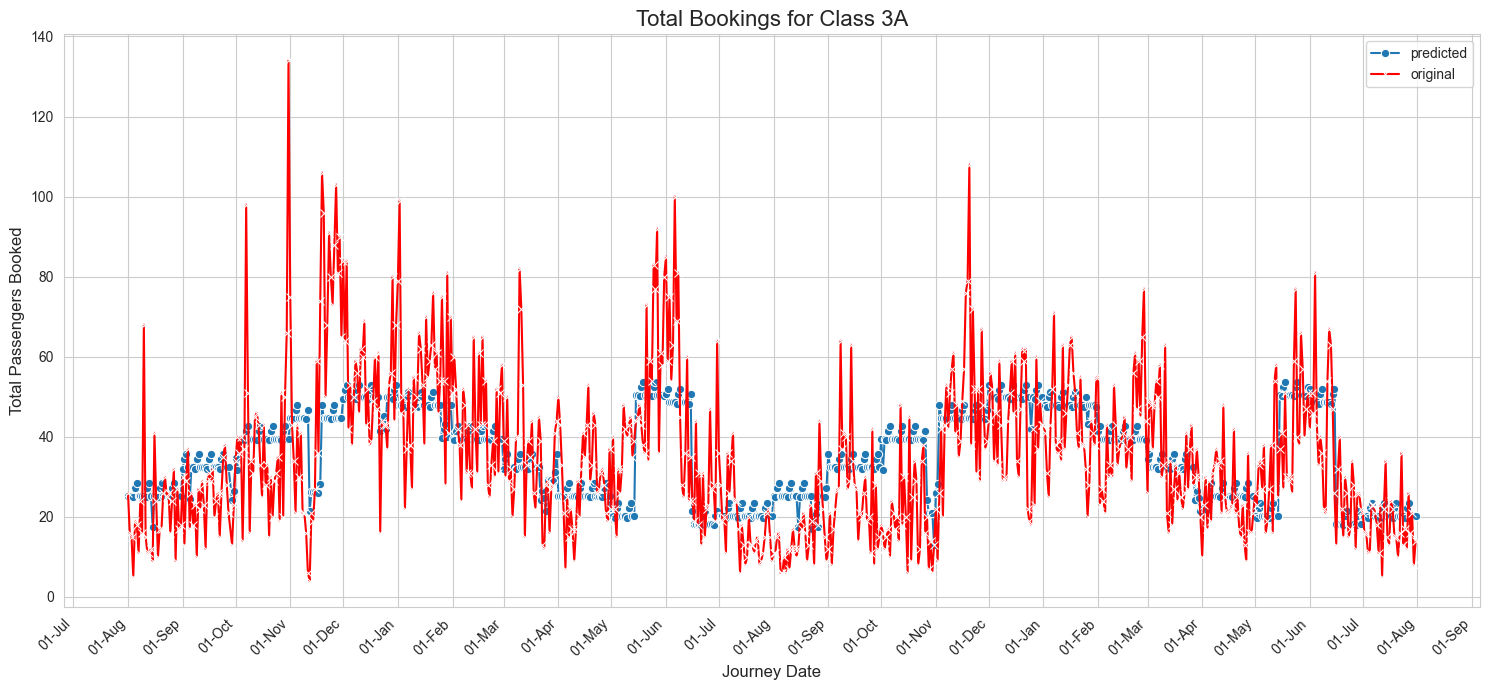

--- Random Forest ---
Train MAE: 11.22  |  Test MAE: 12.58
Train MSE: 210.60  |  Test MSE: 304.54
Train R2 Score: 0.43   |  Test R2 Score: 0.24



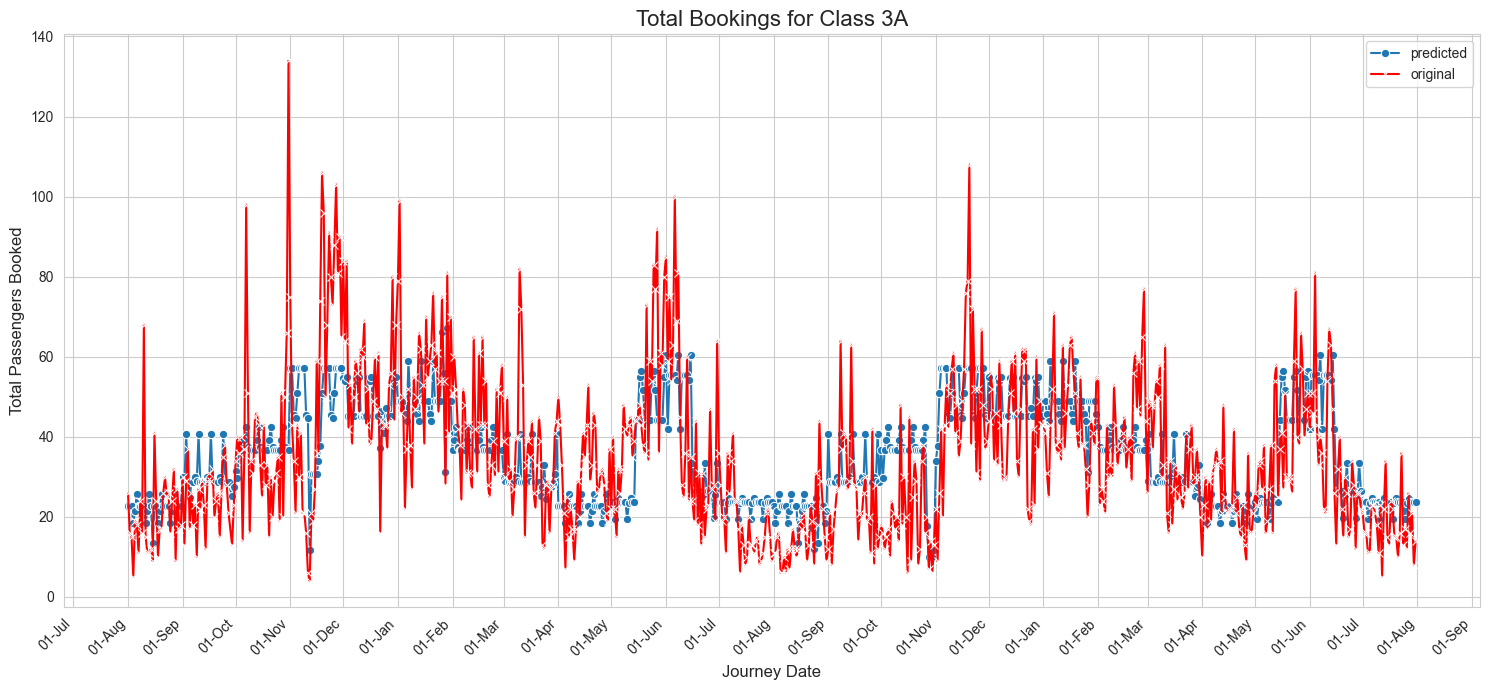

--- XGBoost ---
Train MAE: 10.79  |  Test MAE: 12.61
Train MSE: 203.10  |  Test MSE: 302.72
Train R2 Score: 0.45   |  Test R2 Score: 0.24



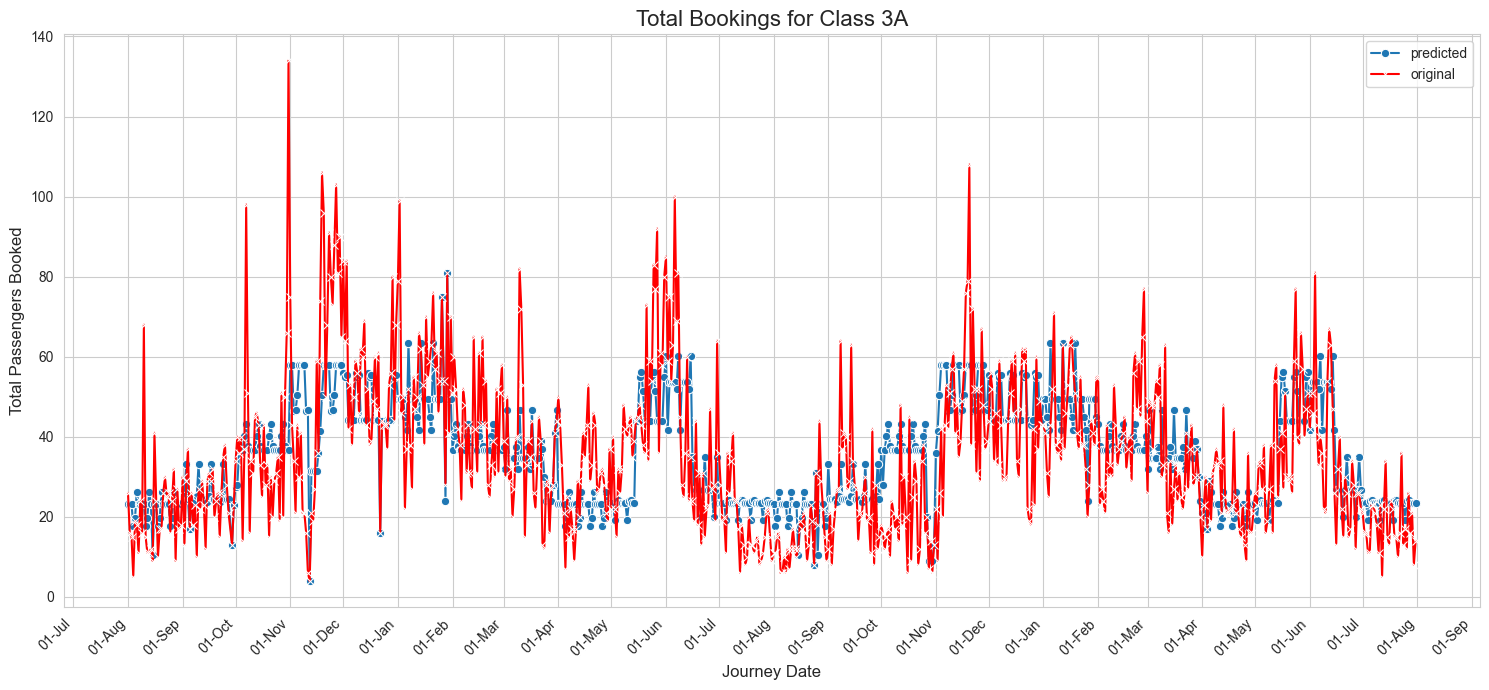

In [18]:
features = [
    'is_sunday', 
    'is_saturday', 
    'is_friday', 
    'is_peak_season', 
    'is_winter_season', 
    'is_holiday_period',
    'month_cos',
    'is_diwali',
    'is_holi',
    # 'day_cos', 
]
X = df[features]
y = df['total_psgn']

# --- 3. Split Data into Training and Testing Sets ---
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 4. Import, Train, and Evaluate Models ---
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42, max_depth=7),
    "XGBoost": XGBRegressor(random_state=42)
}

# Loop to train and evaluate each model

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # --- PREDICTIONS ---
    # Make predictions on the TRAINING set
    y_train_pred = model.predict(X_train)
    # Make predictions on the TEST set
    y_test_pred = model.predict(X_test)

    # --- EVALUATION ---
    # Calculate evaluation metrics for the TRAINING set
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    # Calculate evaluation metrics for the TEST set
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # --- PRINT RESULTS ---
    print(f"--- {name} ---")
    print(f"Train MAE: {train_mae:.2f}  |  Test MAE: {test_mae:.2f}")
    print(f"Train MSE: {train_mse:.2f}  |  Test MSE: {test_mse:.2f}")
    print(f"Train R2 Score: {train_r2:.2f}   |  Test R2 Score: {test_r2:.2f}\n")
    df['predicted_psgn']= model.predict(X)
    plot_booking_graph()